## Algılayıcı

> Bu not defteri, [Yeni Başlayanlar İçin Yapay Zeka Müfredatı](http://github.com/microsoft/ai-for-beginners)'nın bir parçasıdır. Eksiksiz öğrenme materyallerinin tamamı için kod deposunu ziyaret edin.

Tartıştığımız gibi, algılayıcı **ikili sınıflandırma problemini** çözmenize, yani girdi örneklerini iki sınıfa ayırmanıza izin verir - bunlara **pozitif** ve **negatif** diyebiliriz.

İlk olarak, bazı gerekli kütüphaneleri içe aktaralım.

In [1]:
import pylab
from matplotlib import gridspec
from sklearn.datasets import make_classification
import numpy as np
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
import pickle
import os
import gzip

# yeniden üretilebilirlik için tohumu (seed) seçin - rastgele varyasyonların etkilerini keşfetmek için değiştirin
np.random.seed(1)
import random

## Basit Örnek Problem

Başlangıç olarak, iki girdi özniteliğimiz olan bir basit örnek problem ile başlayalım. Örneğin, tıpta tümörleri boyutuna ve yaşına bağlı olarak iyi huylu ve kötü huylu olarak sınıflandırmak isteyebiliriz.

SciKit Learn kütüphanesinden `make_classification` fonksiyonunu kullanarak rastgele bir sınıflandırma veri kümesi oluşturacağız:

In [2]:
n = 50
X, Y = make_classification(n_samples = n, n_features=2,
                           n_redundant=0, n_informative=2, flip_y=0)
Y = Y*2-1 # ilk 0/1 değerlerini -1/1'e çevir
X = X.astype(np.float32); Y = Y.astype(np.int32) # öznitelikler - kayan virgüllü sayı, etiket - tam sayı

# Veri kümesini eğitim ve test olarak ayırın
train_x, test_x = np.split(X, [ n*8//10])
train_labels, test_labels = np.split(Y, [n*8//10])
print("Features:\n",train_x[0:4])
print("Labels:\n",train_labels[0:4])

Features:
 [[-1.7441838  -1.3952037 ]
 [ 2.5921783  -0.08124504]
 [ 0.9218062   0.91789985]
 [-0.8437018  -0.18738253]]
Labels:
 [-1 -1  1 -1]


Let's also plot the dataset:

/var/folders/_l/jnklp1bj4cl95rc01tf5vx4h0000gn/T/ipykernel_48969/3457453734.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


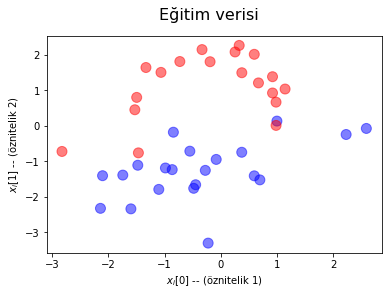

In [4]:
def plot_dataset(suptitle, features, labels):
    # prepare the plot
    fig, ax = pylab.subplots(1, 1)
    #pylab.subplots_adjust(bottom=0.2, wspace=0.4)
    fig.suptitle(suptitle, fontsize = 16)
    ax.set_xlabel('$x_i[0]$ -- (öznitelik 1)')
    ax.set_ylabel('$x_i[1]$ -- (öznitelik 2)')

    colors = ['r' if l>0 else 'b' for l in labels]
    ax.scatter(features[:, 0], features[:, 1], marker='o', c=colors, s=100, alpha = 0.5)
    fig.show()

plot_dataset('Eğitim verisi', train_x, train_labels)

## Algılayıcı

Algılayıcı bir ikili sınıflandırıcı olduğundan, her bir $x$ girdi vektörü için algılayıcımızın çıktısı, sınıfa bağlı olarak +1 veya -1 olacaktır. Çıktı aşağıdaki formül kullanılarak hesaplanacaktır.

$$y(\mathbf{x}) = f(\mathbf{w}^{\mathrm{T}}\mathbf{x})$$

burada $\mathbf{w}$ bir ağırlık vektörüdür, $f$ bir basamak etkinleştirme fonksiyonudur:
$$
f(x) = \begin{cases}
         +1 & x \geq 0 \\
         -1 & x < 0
       \end{cases} \\
$$

Bununla birlikte, genel bir doğrusal modelin de bir ek girdisi olmalıdır, yani ideal olarak $y$'yi $y=f(\mathbf{w}^{\mathrm{T}}\mathbf{x})+\mathbf{b}$ olarak hesaplamalıyız. Modelimizi basitleştirmek için, girdi özniteliklerimize her zaman 1'e eşit olan bir boyut daha ekleyerek bu ek girdi teriminden kurtulabiliriz:

In [5]:
pos_examples = np.array([ [t[0], t[1], 1] for i,t in enumerate(train_x) 
                          if train_labels[i]>0])
neg_examples = np.array([ [t[0], t[1], 1] for i,t in enumerate(train_x) 
                          if train_labels[i]<0])
print(pos_examples[0:3])

[[ 0.92180622  0.91789985  1.        ]
 [-1.06435513  1.49764717  1.        ]
 [ 0.32839951  2.25677919  1.        ]]


## Eğitim Algoritması

Algılayıcıyı eğitmek için, hatayı en aza indirecek $\mathbf{w}$ ağırlıklarını bulmamız gerekiyor. Hata, **algılayıcı kriterleri** kullanılarak tanımlanır:

$$E(\mathbf{w}) = -\sum_{n \in \mathcal{M}}\mathbf{w}^{\mathrm{T}}\mathbf{x}_{n}t_{n}$$
 
  * $t_{n} \in \{-1, +1\}$ for negative and positive training samples, respectively
  * $\mathcal{M}$ - a set of wrongly classified examples

**Gradyan inişi** işlemini kullanacağız. Bazı rastgele ilk $\mathbf{w}^{(0)}$ ağırlıkları ile başlayarak, $E$'nin gradyanını kullanarak eğitimin her adımındaki ağırlıkları ayarlayacağız:

$$\mathbf{w}^{\tau + 1}=\mathbf{w}^{\tau} - \eta \nabla E(\mathbf{w}) = \mathbf{w}^{\tau} + \eta \mathbf{x}_{n} t_{n}$$

burada $\eta$ **öğrenme oranı** ve $\tau\in\mathbb{N}$ yineleme sayısıdır.

Bu algoritmayı Python'da tanımlayalım:

In [6]:
def train(positive_examples, negative_examples, num_iterations = 100):
    num_dims = positive_examples.shape[1]
    
    # Ağırlıkları ilkle.
    # Basitlik için 0 ile ilkletiyoruz, ancak rastgele ilkleme de iyi bir fikirdir
    weights = np.zeros((num_dims,1)) 
    
    pos_count = positive_examples.shape[0]
    neg_count = negative_examples.shape[0]
    
    report_frequency = 10
    
    for i in range(num_iterations):
        # Bir pozitif ve bir negatif örnek seçin
        pos = random.choice(positive_examples)
        neg = random.choice(negative_examples)

        z = np.dot(pos, weights)   
        if z < 0: # pozitif örnek negatif olarak sınıflandırıldı
            weights = weights + pos.reshape(weights.shape)

        z  = np.dot(neg, weights)
        if z >= 0: # negatif örnek pozitif olarak sınıflandırıldı
            weights = weights - neg.reshape(weights.shape)
            
        # Periyodik olarak, tüm örneklerde mevcut doğruluğu yazdırın
        if i % report_frequency == 0:             
            pos_out = np.dot(positive_examples, weights)
            neg_out = np.dot(negative_examples, weights)        
            pos_correct = (pos_out >= 0).sum() / float(pos_count)
            neg_correct = (neg_out < 0).sum() / float(neg_count)
            print("Yineleme={}, positif doğruluk={}, negatif doğruluk={}".format(i,pos_correct,neg_correct))

    return weights

Şimdi eğitimi veri kümemizde çalıştıralım:

In [7]:
wts = train(pos_examples,neg_examples)
print(wts.transpose())

Yineleme=0, positif doğruluk=0.7368421052631579, negatif doğruluk=0.8571428571428571
Yineleme=10, positif doğruluk=0.8421052631578947, negatif doğruluk=1.0
Yineleme=20, positif doğruluk=0.8421052631578947, negatif doğruluk=1.0
Yineleme=30, positif doğruluk=0.8947368421052632, negatif doğruluk=0.8571428571428571
Yineleme=40, positif doğruluk=0.8947368421052632, negatif doğruluk=0.8095238095238095
Yineleme=50, positif doğruluk=0.8421052631578947, negatif doğruluk=0.9523809523809523
Yineleme=60, positif doğruluk=0.8421052631578947, negatif doğruluk=0.9523809523809523
Yineleme=70, positif doğruluk=0.9473684210526315, negatif doğruluk=0.8095238095238095
Yineleme=80, positif doğruluk=1.0, negatif doğruluk=0.7619047619047619
Yineleme=90, positif doğruluk=0.8947368421052632, negatif doğruluk=0.9047619047619048
[[-0.30137426  5.42483654  0.        ]]


Gördüğünüz gibi, ilk doğruluk %50 civarındadır, ancak hızla %90'a yakın daha yüksek değerlere çıkar.

Sınıfların nasıl ayrıldığını görselleştirelim. Sınıflandırma fonksiyonumuz $\mathbf{w}^Tx$ gibi görünüyor ve bir sınıf için 0'dan büyük, diğeri için 0'ın altında. Böylece, sınıf ayırma doğrusu $\mathbf{w}^Tx = 0$ ile tanımlanır. Yalnızca $x_0$ ve $x_1$ boyutlarına sahip olduğumuz için, doğrunun denklemi $w_0x_0+w_1x_1+w_2 = 0$ olacaktır (ekstra bir boyut olarak $x_2=1$ tanımladığımızı unutmayın). Bu doğruyu çizelim:

In [8]:
def plot_boundary(positive_examples, negative_examples, weights):
    if np.isclose(weights[1], 0):
        if np.isclose(weights[0], 0):
            x = y = np.array([-6, 6], dtype = 'float32')
        else:
            y = np.array([-6, 6], dtype='float32')
            x = -(weights[1] * y + weights[2])/weights[0]
    else:
        x = np.array([-6, 6], dtype='float32')
        y = -(weights[0] * x + weights[2])/weights[1]

    pylab.xlim(-6, 6)
    pylab.ylim(-6, 6)                      
    pylab.plot(positive_examples[:,0], positive_examples[:,1], 'bo')
    pylab.plot(negative_examples[:,0], negative_examples[:,1], 'ro')
    pylab.plot(x, y, 'g', linewidth=2.0)
    pylab.show()

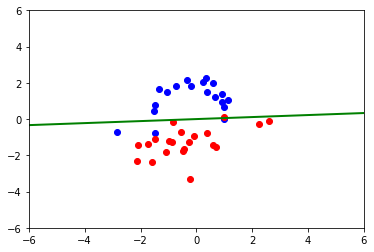

In [9]:
plot_boundary(pos_examples,neg_examples,wts)

## Test Veri Kümesinde Değerlendirme

Başlangıçta, bazı verileri test veri kümesine ayırdık. Bu test veri kümesinde sınıflandırıcımızın ne kadar doğru olduğunu görelim. Bunu yapmak için ayrıca test veri kümesini ekstra bir boyutla genişletiyoruz, ağırlıklar matrisi ile çarpıyoruz ve elde edilen değerin etiketle (+1 veya -1) aynı işarette olduğundan emin oluyoruz. Daha sonra doğruluğu elde etmek için tüm boole değerlerini toplarız ve test örnekleminin uzunluğuna böleriz:

In [10]:
def accuracy(weights, test_x, test_labels):
    res = np.dot(np.c_[test_x,np.ones(len(test_x))],weights)
    return (res.reshape(test_labels.shape)*test_labels>=0).sum()/float(len(test_labels))

accuracy(wts, test_x, test_labels)

1.0

## Eğitim sürecini gözlemlemek

Eğitim sırasında doğruluğun nasıl azaldığını daha önce gördük. Eğitim sırasında ayırma doğrusunun nasıl davrandığını görmek güzel olurdu. Aşağıdaki kod, her şeyi tek bir grafikte görselleştirecektir ve kaydırıcıyı eğitim süreci boyunca "zaman yolculuğu"na hareket ettirebilmelisiniz.

In [11]:
def train_graph(positive_examples, negative_examples, num_iterations = 100):
    num_dims = positive_examples.shape[1]
    weights = np.zeros((num_dims,1)) # ağırlıkları ilkle
    
    pos_count = positive_examples.shape[0]
    neg_count = negative_examples.shape[0]
    
    report_frequency = 15;
    snapshots = []
    
    for i in range(num_iterations):
        pos = random.choice(positive_examples)
        neg = random.choice(negative_examples)

        z = np.dot(pos, weights)   
        if z < 0:
            weights = weights + pos.reshape(weights.shape)

        z  = np.dot(neg, weights)
        if z >= 0:
            weights = weights - neg.reshape(weights.shape)
            
        if i % report_frequency == 0:             
            pos_out = np.dot(positive_examples, weights)
            neg_out = np.dot(negative_examples, weights)        
            pos_correct = (pos_out >= 0).sum() / float(pos_count)
            neg_correct = (neg_out < 0).sum() / float(neg_count)
            snapshots.append((np.copy(weights),(pos_correct+neg_correct)/2.0))

    return np.array(snapshots)

snapshots = train_graph(pos_examples,neg_examples)

def plotit(pos_examples,neg_examples,snapshots,step):
    fig = pylab.figure(figsize=(10,4))
    fig.add_subplot(1, 2, 1)
    plot_boundary(pos_examples, neg_examples, snapshots[step][0])
    fig.add_subplot(1, 2, 2)
    pylab.plot(np.arange(len(snapshots[:,1])), snapshots[:,1])
    pylab.ylabel('Accuracy')
    pylab.xlabel('Iteration')
    pylab.plot(step, snapshots[step,1], "bo")
    pylab.show()
def pl1(step): plotit(pos_examples,neg_examples,snapshots,step)

/var/folders/_l/jnklp1bj4cl95rc01tf5vx4h0000gn/T/ipykernel_48969/1624475785.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(snapshots)


In [12]:
interact(pl1, step=widgets.IntSlider(value=0, min=0, max=len(snapshots)-1))

interactive(children=(IntSlider(value=0, description='step', max=6), Output()), _dom_classes=('widget-interact…

<function __main__.pl1(step)>

## Algılayıcının Sınırları

Yukarıda gördüğünüz gibi, algılayıcı bir **doğrusal sınıflandırıcıdır**. **Doğrusal olarak ayrılabilir** iseler, yani düz bir çizgi ile ayrılabilirlerse, iki sınıf arasında iyi bir ayrım yapabilir. Aksi takdirde, algılayıcı eğitim işlemi yakınsamayacaktır.

Bir algılayıcı tarafından çözülemeyen bir problemin en bariz örneği **XOR problemi** olarak adlandırılır. Algılayıcımızın aşağıdaki doğruluk tablosuna sahip olan XOR boole işlevini öğrenmesini istiyoruz:

|   | 0 | 1 |
|---|---|---|
| 0 | 0 | 1 | 
| 1 | 1 | 0 |

Hadi bunu deneyelim ve yapalım! Tüm pozitif ve negatif eğitim örneklerini manuel olarak dolduracağız ve ardından yukarıda tanımlanan eğitim fonksiyonumuzu çağıracağız:

In [13]:
pos_examples_xor = np.array([[1,0,1],[0,1,1]])
neg_examples_xor = np.array([[1,1,1],[0,0,1]])

snapshots_xor = train_graph(pos_examples_xor,neg_examples_xor,1000)
def pl2(step): plotit(pos_examples_xor,neg_examples_xor,snapshots_xor,step)

/var/folders/_l/jnklp1bj4cl95rc01tf5vx4h0000gn/T/ipykernel_48969/1624475785.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(snapshots)


In [14]:
interact(pl2, step=widgets.IntSlider(value=0, min=0, max=len(snapshots)-1))

interactive(children=(IntSlider(value=0, description='step', max=6), Output()), _dom_classes=('widget-interact…

<function __main__.pl2(step)>

Yukarıdaki grafikten de görebileceğiniz gibi, doğruluk hiçbir zaman %75'in üzerine çıkmaz, çünkü olası tüm örnekleri doğru elde edecek şekilde düz bir çizgi çizmek imkansızdır.

XOR problemi, algılayıcının sınırlarının klasik bir örneğidir ve 1969'da Marvin Minsky ve Seymour Papert tarafından [Algılayıcılar](https://en.wikipedia.org/wiki/Perceptrons_(book)) adlı kitaplarında belirtilmiştir. Bu gözlem, sinir ağları alanındaki araştırmayı neredeyse 10 yıllarca sınırlandırdı - ve bunu kursumuzun bir sonraki bölümünde göreceğiz - çok katmanlı algılayıcılar bu tür sorunları mükemmel bir şekilde çözme yeteneğine sahipler.

## Karmaşık Örnek - MNIST

Perceptron, XOR problemini çözemese de, el yazısı karakter tanıma gibi daha birçok karmaşık problemi çözebilir.

Makine öğrenmesinde uzmanlaşırken sıklıkla kullanılan bir veri kümesine [MNIST](https://en.wikipedia.org/wiki/MNIST_database) denir. Modifiye Ulusal Standartlar ve Teknoloji Enstitüsü tarafından oluşturulmuştur ve yaklaşık 250 öğrenci ve enstitü çalışanından toplanan 60000 el yazısıyla yazılmış rakamdan bir eğitim kümesi içerir. Ayrıca farklı kişilerden toplanan 10000 rakamlık bir test veri kümesi de bulunmaktadır.

Tüm rakamlar, 28x28 piksel boyutundaki gri tonlamalı imgelerle temsil edilir.

> MNIST veri Kümesi, makine öğrenmesi yarışmalarına ve mücadelelerine ev sahipliği yapan bir site olan [Kaggle](https://www.kaggle.com/c/digit-recognizer) üzerinde bir eğitim yarışması olarak mevcuttur. MNIST rakamlarını nasıl sınıflandıracağınızı öğrendikten sonra, diğer katılımcılar arasında nasıl derecelendirildiğini görmek için çözümünüzü Kaggle'a gönderebilirsiniz.

MNIST veri kğmesini yükleyerek başlıyoruz:

In [15]:
# Bu not defterini klonlanmış bir depodan çalıştırmıyorsanız, önce ikili veri kümesi dosyasını almanız gerekebilir.
# !wget https://raw.githubusercontent.com/microsoft/AI-For-Beginners/main/data/mnist.pkl.gz
# Bu durumda aşağıdaki veri kümesinin bağlantısını da düzeltin.

with gzip.open('../../data/mnist.pkl.gz', 'rb') as mnist_pickle:
    MNIST = pickle.load(mnist_pickle)

Şimdi veri kümesini çizelim:

[  0   0 188 255  94   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0 191 250 253  93   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
1


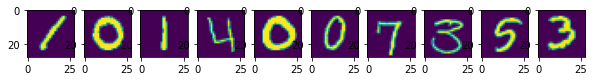

In [16]:
print(MNIST['Train']['Features'][0][130:180])
print(MNIST['Train']['Labels'][0])
features = MNIST['Train']['Features'].astype(np.float32) / 256.0
labels = MNIST['Train']['Labels']
fig = pylab.figure(figsize=(10,5))
for i in range(10):
    ax = fig.add_subplot(1,10,i+1)
    pylab.imshow(features[i].reshape(28,28))
pylab.show()

Algılayıcı bir ikili sınıflandırıcı olduğundan, problemimizi sadece iki rakamı tanımakla sınırlayacağız. Aşağıdaki işlev, pozitif ve negatif örnek dizilerini verilen iki rakam ile dolduracaktır (ve ayrıca netlik için bu rakamların örneklerini de gösterecektir).

In [17]:
def set_mnist_pos_neg(positive_label, negative_label):
    positive_indices = [i for i, j in enumerate(MNIST['Train']['Labels']) 
                          if j == positive_label]
    negative_indices = [i for i, j in enumerate(MNIST['Train']['Labels']) 
                          if j == negative_label]

    positive_images = MNIST['Train']['Features'][positive_indices]
    negative_images = MNIST['Train']['Features'][negative_indices]

    fig = pylab.figure()
    ax = fig.add_subplot(1, 2, 1)
    pylab.imshow(positive_images[0].reshape(28,28), cmap='gray', interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    ax = fig.add_subplot(1, 2, 2)
    pylab.imshow(negative_images[0].reshape(28,28), cmap='gray', interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    pylab.show()
    
    return positive_images, negative_images

0 ile 1 arasında sınıflandırma yapmaya çalışarak başlayacağız:

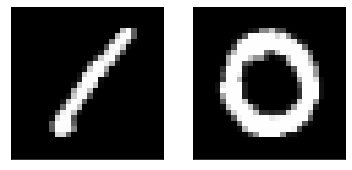

In [19]:
pos1,neg1 = set_mnist_pos_neg(1,0)

In [20]:
def plotit2(snapshots_mn,step):
    fig = pylab.figure(figsize=(10,4))
    ax = fig.add_subplot(1, 2, 1)
    pylab.imshow(snapshots_mn[step][0].reshape(28, 28), interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    pylab.colorbar()
    ax = fig.add_subplot(1, 2, 2)
    ax.set_ylim([0,1])
    pylab.plot(np.arange(len(snapshots_mn[:,1])), snapshots_mn[:,1])
    pylab.plot(step, snapshots_mn[step,1], "bo")
    pylab.show()
def pl3(step): plotit2(snapshots_mn,step)
def pl4(step): plotit2(snapshots_mn2,step)    

In [21]:
snapshots_mn = train_graph(pos1,neg1,1000)    
interact(pl3, step=widgets.IntSlider(value=0, min=0, max=len(snapshots_mn) - 1))

interactive(children=(IntSlider(value=0, description='step', max=66), Output()), _dom_classes=('widget-interac…

<function __main__.pl3(step)>

Lütfen doğruluğun çok hızlı bir şekilde neredeyse %100'e kadar çıktığına dikkat edin.

Lütfen, kaydırıcıyı eğitimin sonuna doğru bir konuma getirin ve solda çizilen ağırlık matrisini gözlemleyin. Bu matris, algılayıcının gerçekte nasıl çalıştığını anlamanıza izin verecektir. Alanın ortasında tipik olarak 1 rakamı için mevcut olan piksellere karşılık gelen yüksek ağırlık değerlerini ve 0 rakamı bölümlerinin olduğu kenarlarda düşük negatif değerlerini görebilirsiniz. Yani, algılayıcıya sunulan rakam aslında 1 ise, orta kısmı yüksek değerlerle çarpılarak pozitif sonuç üretilecektir. Tersine, algılayıcı 0'ı gözlemlediğinde, karşılık gelen pikseller negatif sayılarla çarpılacaktır.

> Algılayıcımıza yatay olarak hafifçe kaydırılmış bir 1 rakamı verirsek, öyleki pikselleri 0'ın dikey kısımlarının olduğu yeri doldursun, yanlış sonuç alabileceğimizi fark edebilirsiniz. MNIST veri kümemizin doğası gereği, tüm rakamlar ortalanmış ve düzgün bir şekilde konumlandırılmıştır ve algılayıcı, rakamları ayırt etmek için buna güvenir.

Şimdi farklı rakamlar deneyelim:

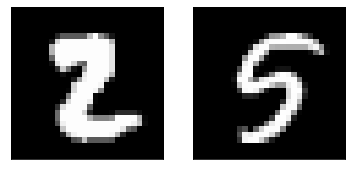

In [22]:
pos2,neg2 = set_mnist_pos_neg(2,5)

In [23]:
snapshots_mn2 = train_graph(pos2,neg2,1000)
interact(pl4, step=widgets.IntSlider(value=0, min=0, max=len(snapshots_mn2) - 1))

interactive(children=(IntSlider(value=0, description='step', max=66), Output()), _dom_classes=('widget-interac…

<function __main__.pl4(step)>

## Vargılar 

Nedense 2 ve 5 o kadar kolay ayrılamaz. Nispeten yüksek doğruluk elde etmemize rağmen (%85'in üzerinde), algılayıcının bir noktada öğrenmeyi nasıl durdurduğunu açıkça görebiliriz.

Bunun neden olduğunu anlamak için [Temel Bileşen Analizi](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA) kullanmayı deneyebiliriz. Sınıflar arasında en iyi ayrılabilirliği elde edecek şekilde girdi veri kümesinin boyutunu azaltmak için kullanılan bir makine öğrenmesi tekniğidir.

Bizim durumumuzda, bir girdi imgesi 784 piksele (girdi öznitelikleri) sahiptir ve parametre sayısını sadece 2'ye düşürmek için PCA'yı kullanmak istiyoruz, böylece bunları grafik üzerinde çizebiliriz. Bu iki parametre, orijinal özniteliklerin doğrusal bir birleşimi olacaktır ve bu prosedürü, sınıfları ayıran en iyi görünümü elde edene kadar orijinal 784 boyutlu uzayımızı "döndürmek" ve 2B uzayımıza izdüşümü gözlemlemek olarak görebiliriz.

In [24]:
from sklearn.decomposition import PCA

def pca_analysis(positive_label, negative_label):
    positive_images, negative_images = set_mnist_pos_neg(positive_label, negative_label)
    M = np.append(positive_images, negative_images, 0)

    mypca = PCA(n_components=2)
    mypca.fit(M)
    
    pos_points = mypca.transform(positive_images[:200])
    neg_points = mypca.transform(negative_images[:200])

    pylab.plot(pos_points[:,0], pos_points[:,1], 'bo')
    pylab.plot(neg_points[:,0], neg_points[:,1], 'ro')

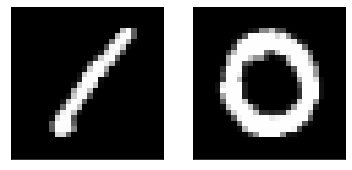

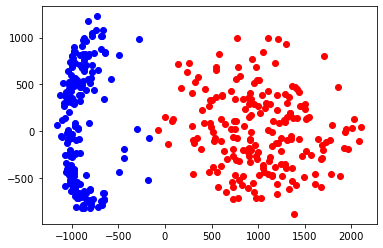

In [25]:
pca_analysis(1,0)

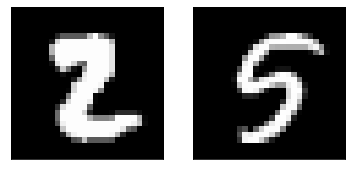

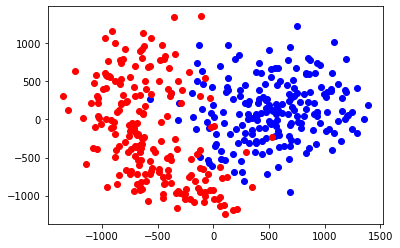

In [26]:
pca_analysis(2,5)

Gördüğünüz gibi, 0 ve 1 düz bir çizgi ile net bir şekilde ayrılabilir. Bu, orijinal 784 boyutlu uzayda rakamlara karşılık gelen noktaların da doğrusal olarak ayrılabilir olduğunu gösterir. 2 ve 5 durumunda, rakamları net bir şekilde ayıracak iyi bir izdüşüm bulamıyoruz ve bu nedenle bazı yanlış sınıflandırma durumları var.

> Bu kursun ilerleyen bölümlerinde, Sinir Ağlarını kullanarak doğrusal olmayan sınıflandırıcıların nasıl oluşturulacağını ve rakamların düzgün şekilde hizalanmaması sorunuyla nasıl başa çıkılacağını öğreneceğiz. Çok yakında 10 farklı sınıfa ayırarak MNIST rakam sınıflandırmasında %99'un üzerinde doğruluğa ulaşacağız.

## Ana Fikirler
 * En basit sinir ağı mimarisini öğrendik - tek katmanlı algılayıcı.
 * Gradyan inişine dayalı basit eğitim prosedürünü kullanarak algılayıcıyı "elle" uyguladık.
 * Basitliğine rağmen, tek katmanlı algılayıcı, el yazısı rakam tanımanın oldukça karmaşık problemlerini çözebilir.
 * Tek katmanlı algılayıcı bir doğrusal sınıflandırıcıdır ve bu nedenle lojistik bağlanım (regresyon) ile aynı sınıflandırma gücünü sağlar.
 * Örneklem uzayında, algılayıcı hiperdüzlem kullanarak iki sınıf girdi verisini ayırabilir.

## Katkıda Bulunanlar

Bu defter, [Yeni Başlayanlar için Yapay Zeka Müfredatı](http://github.com/microsoft/ai-for-beginners)'nın bir parçasıdır ve [Dmitry Soshnikov](http://soshnikov.com) tarafından hazırlanmıştır. Microsoft Research Cambridge'deki Neural Network Workshop'tan ilham almıştır. Bazı kodlar ve açıklayıcı materyaller [Katja Hoffmann](https://www.microsoft.com/en-us/research/people/kahofman/)'ın, [Matthew Johnson](https://www.microsoft.com/en-us/research/people/matjoh/)'ın ve [Ryoto Tomioka](https://www.microsoft.com/en-us/research/people/ryoto/)'nın sunumlarından ve [NeuroWorkshop](http://github.com/shwars/NeuroWorkshop) deposundan alınmıştır.